In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

## Pull dataset names and yaml file name from the yaml descibes repository

In [3]:
yamlDir = "."
yaml_file = yamlDir + "/submission.yaml"
yaml_entries = []  # List to store parsed documents

with open(yaml_file, "r") as stream:
    try:
        yaml_entries = list(yaml.safe_load_all(stream))  # Load all YAML documents
    except yaml.YAMLError as exc:
        print(exc)

# Example: Accessing name and data_file from each entry
file_list = []
list_name = []
for entry in yaml_entries:
    file_list.append(entry.get('data_file'))
    list_name.append(entry.get('name'))
    print(entry.get('name'))

1$\gamma$Xp Shower Energy
1$\gamma$Xp Shower Energy Constrained Covariance Matrix
1$\gamma$Xp Shower Energy Unconstrained Covariance Matrix
1$\gamma$Xp Shower Angle
1$\gamma$Xp Shower Angle Constrained Covariance Matrix
1$\gamma$Xp Shower Angle Unconstrained Covariance Matrix
1$\gamma$Xp Number of Protons
1$\gamma$0p Shower Energy
1$\gamma$0p Shower Energy Constrained Covariance Matrix
1$\gamma$0p Shower Energy Unconstrained Covariance Matrix
1$\gamma$0p Shower Energy - LEE Model
1$\gamma$0p Shower Energy LEE Model Constrained Covariance
1$\gamma$0p Shower Energy LEE Model Unconstrained Covariance
1$\gamma$0p Shower Backwards Projected Distance
1$\gamma$0p Shower Angle
1$\gamma$0p Shower Angle Constrained Covariance Matrix
1$\gamma$0p Shower Angle Unconstrained Covariance Matrix
1$\gamma$Xp 2D Efficiency
1$\gamma$0p 2D Efficiency


## Create Function to pull data columns (after first column)

In [4]:
def pull_dependent_vars(data_list_here):    
    data_series = {}
    save_names = []
    for entry in data_list_here:
        name_here = entry['header']['name']
        save_names.append(name_here)
        values = []
        errors = []

        for v in entry['values']:
            values.append(v['value'])
            if 'errors' in v and v['errors']:  # Check for presence of errors
                if 'asymerror' in v['errors'][0]:
                    err_minus = -v['errors'][0]['asymerror']['minus']
                    err_plus = v['errors'][0]['asymerror']['plus']
                else:
                    err_minus = v['errors'][0]['symerror']
                    err_plus = v['errors'][0]['symerror']
            else:
                err_minus, err_plus = 0, 0  # Default to no error if missing

            errors.append([err_minus, err_plus])

        data_series[name_here] = {'values': values, 'errors': np.array(errors).T}  # Transpose errors
    size = len(data_series[name_here]["values"])
    return data_series, size, save_names

#### Identify which titles are for 2D vs. 1D plots (look at your dataset in HEPdata, set up for this case)

In [5]:
file_list_eff = []
file_name_eff = []
file_list_cov = []
file_name_cov = []
file_list_1D = []
file_name_1D = []
for i in range(len(list_name)):
    if "Covariance" in list_name[i]:
        file_list_cov.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_cov.append(list_name[i])
    elif "Efficiency" in list_name[i]: #identify
        file_list_eff.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_eff.append(list_name[i])
    else:
        file_list_1D.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_1D.append(list_name[i])

## 1D Plots for Data and MC

In [6]:
yaml_names = file_list_1D
yaml_name_pretty = file_name_1D
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
yaml_dict_1D = yaml_dict

xpshoweren
Xp_shwang
numpro
0p_shwen600
0p_shwen_150_1250
0p_backprojdist
0p_shwang


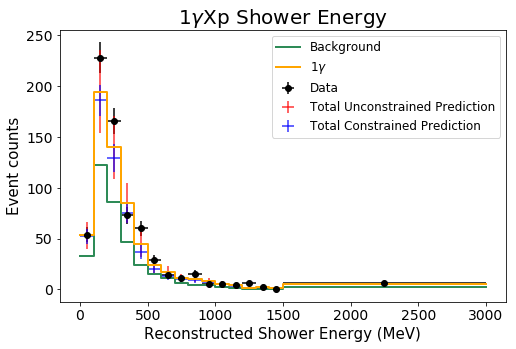

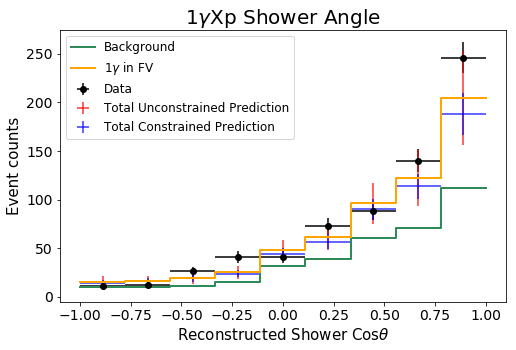

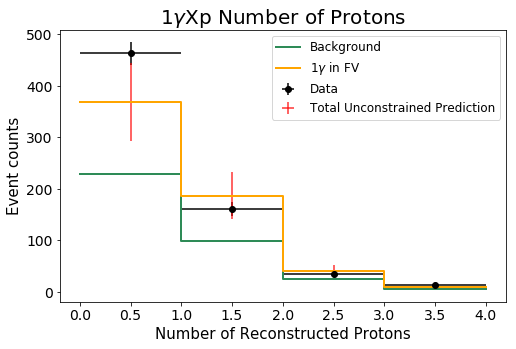

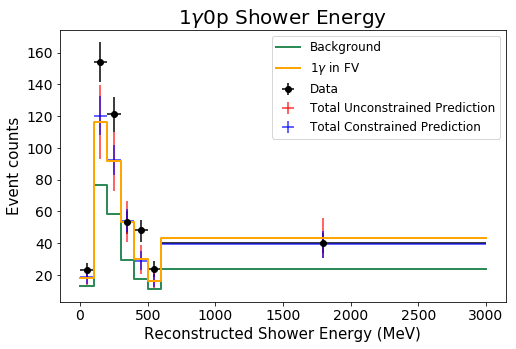

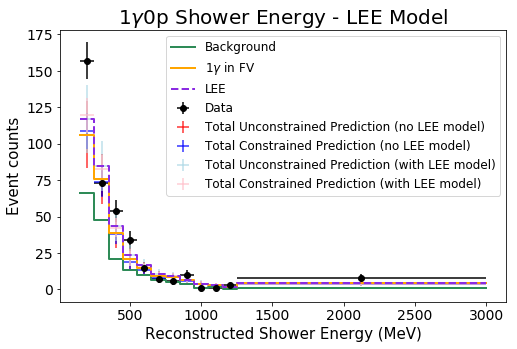

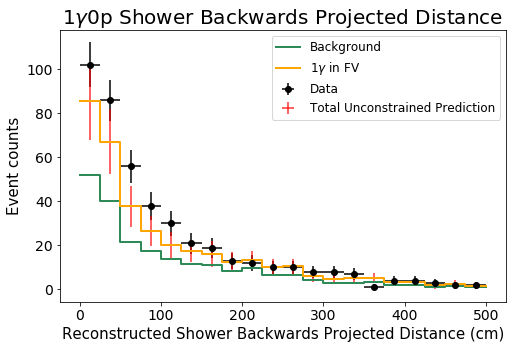

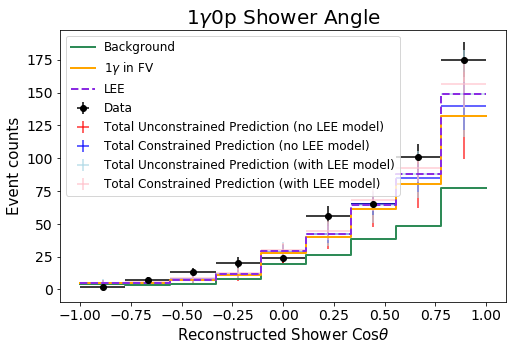

In [29]:
color_data = ["red","blue","lightblue","pink"]
color_other = ["seagreen","orange","cyan","brown","gray","magenta"]

for i in range(len(yaml_names)):
    
    #### PULL 1D DATASET X-AXIS #######
    
    #Check for 1D, only 1 indepedent variable
    i_vars = 0 #index for single independent variable
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 1, "Plotting 1D only"
    indep_var = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]
        
    center = []
    bin_low = []
    bin_high = []
    xerrors = []
    for v in indep_var['values']:
        center.append((v['low']+v['high'])/2)
        bin_low.append(v['low'])
        bin_high.append(v['high'])
        xerrors.append((v['high']-v['low'])/2.)
    x_values = center
    bin_low.append(bin_high[-1]) #for step histogram, need final step line plotted

    #### PULL DATASET COLUMNS  ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]
    
    # Extract y-values and errors
    data_series, size, col_names = pull_dependent_vars(data_list) 
    

    ### PLOT DATASETS INSIDE SAME FIGURE ####
    ### Handles colors up to 7 MC and 4 Prediction (not counting Data and LEE model)#######
    plt.figure(figsize=(8, 5))
    co = 0
    cd = 0
    list_size = size + 1 #Extra entry to finish the step plot line in final bin
    stacked_values = np.zeros(list_size)
    save_LEE_end = None
    save_name = None
    for name, series in data_series.items():

        y_values = series['values']
        y_errors = np.array(series['errors'])  # Transpose to match errorbar forma
        #print(len(x_values),len(y_values),len(y_errors))

        if name == "Data": #Data in black marker points with error bars
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt='o',
                         label=name,color="k")
        elif "Prediction" in name: #Prediction in connected marker points with error bars
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt='none',
                         label=name,color=color_data[cd],alpha=0.8)
            cd+=1
        elif np.all(y_errors == 0): #MC Background and signal do not have error included
            y_hist_plot = y_values
            y_hist_plot.append(y_values[-1])
            if "LEE" in name: #LEE model should be additional on top of all MC, save to plot at end
                save_LEE_end = y_hist_plot
                save_name = name
            else: #Normal MC
                plt.step(bin_low, stacked_values + y_hist_plot, where='post',
                         label=name,linewidth=2, color=color_other[co])
                stacked_values += y_values
            co+=1
        else:
            print("DONT RECOGNIZE THIS NAME")
            
        

    if save_LEE_end is not None: #If it found an LEE, plot on top of MC stack
        plt.step(bin_low, np.array(stacked_values) + np.array(save_LEE_end), where='post', label=save_name,
                     linewidth=2, linestyle="--",color="blueviolet")

        
    # Format plot
    plt.title(yaml_name_pretty[i],fontsize=20)
    try:
        units = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["units"]
    except:
        units = None
    if units is not None:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"] 
               + " (" + units + ")",fontsize=15)
    else:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"],
                    fontsize=15)
    plt.ylabel("Event counts",fontsize=15)
    plt.xticks(fontsize=14)  # Bigger x-axis ticks
    plt.yticks(fontsize=14) 
    plt.legend(ncol=1,fontsize=12)
    plt.savefig(yamlDir + "/plot_" + yaml_names[i] + ".png")

## 2D Efficiency Plots

In [28]:
yaml_names = file_list_eff
yaml_name_pretty = file_name_eff
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

Xpeffs
0peffs


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500] [-1.  -0.8 -0.6 -0.3 -0.1  0.1  0.3  0.6  0.8  1. ]
[ 150  250  350  450  550  650  750  850  950 1050 1150 1250] [-1.  -0.8 -0.6 -0.3 -0.1  0.1  0.3  0.6  0.8  1. ]


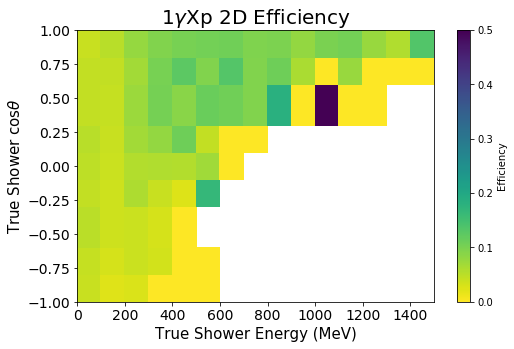

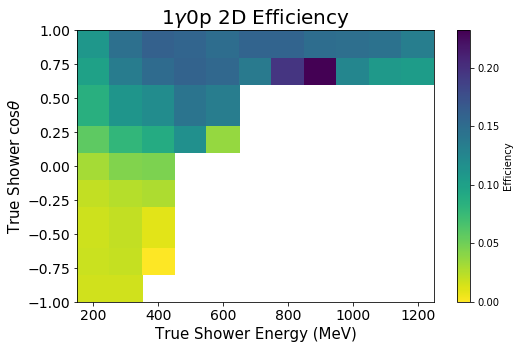

In [41]:
for i in range(len(yaml_names)):
    
    #### PULL 2D DATASET X-AXIS #######
    
    #Check for 2D, 2 and only 2 indepedent variables
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[yaml_names[i]]["independent_variables"][0]
    indep_var2 = yaml_dict[yaml_names[i]]["independent_variables"][1]
    var1_header = yaml_dict[yaml_names[i]]["independent_variables"][0]["header"]
    var2_header = yaml_dict[yaml_names[i]]["independent_variables"][1]["header"]

    assert len(indep_var1["values"]) == len(indep_var2["values"])
    
    #### PULL DATASET COLUMNS, if more than 1, make more than 1 plot ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values per column
    data_series = {}
    for entry in data_list:
        name = entry['header']['name']
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])

        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))
        X_bin = (X[1:] - X[:-1]) #bin sizes for plots
        Y_bin = (Y[1:] - Y[:-1])
        X_bin = np.append(X_bin, X_bin[-1]) #Guessing upper bound, since it's not given
        Y_bin = np.append(Y_bin,Y_bin[-1]) #Guessing upper bound, since it's not given
           
        # Fill Z matrix
        for yi in range(len(Y)):
            for xi in range(len(X)):
                Z[xi, yi] = z_values[yi*len(X)+xi] #y values are backwards, starting from -9
        plt.figure(figsize=(8, 5))
        X_plot = np.append(X, X[-1]+X_bin[-1]) #pcolormesh needs len(X) + 1 to plot all of Z
        Y_plot = np.append(Y,Y[-1]+Y_bin[-1]) #pcolormesh needs len(Y) + 1 to plot all of Z
        plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis_r')  # Transpose Z to match orientation
        

        # Format plot
        plt.title(yaml_name_pretty[i],fontsize=20)
        plt.colorbar(label=name)
        plt.xlabel(var1_header["name"],fontsize=15)
        plt.ylabel(var2_header["name"],fontsize=15)
        plt.xticks(fontsize=14)  # Bigger x-axis ticks
        plt.yticks(fontsize=14) 
        #plt.legend()
        plt.savefig(yamlDir + "/plot_" + yaml_names[i] + "_" + zvar_name + ".png",bbox="tight")
        

## Covariance Matrix

In [7]:
yaml_names = file_list_cov
yaml_name_pretty = file_name_cov
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

xpshowerencovwiCon
xpshowerencovnoCon
Xp_shwang_cov_wiCon
Xp_shwang_cov_noCon
0p_shwen600_cov_wiCon
0p_shwen600_cov_noCon
0p_shwen_150_1250_cov_wiCon
0p_shwen_150_1250_cov_noCon
0p_shwang_cov_wiCon
0p_shwang_cov_noCon


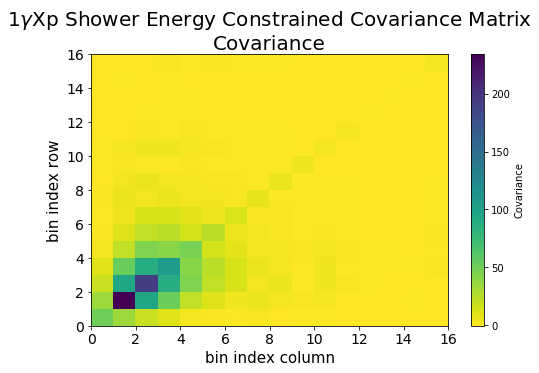

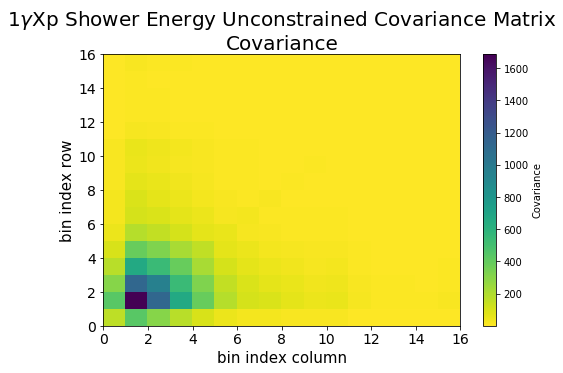

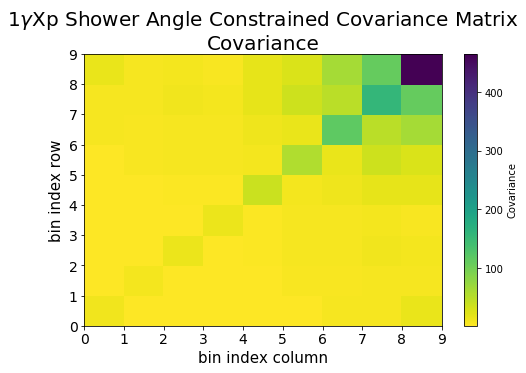

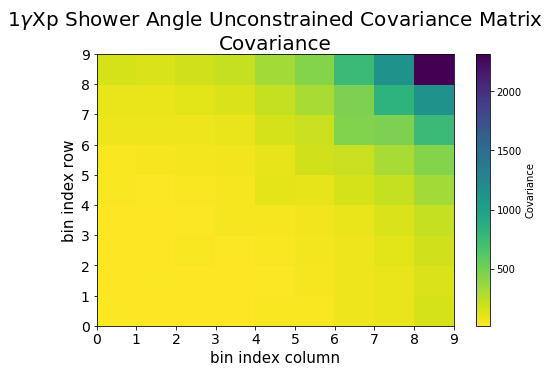

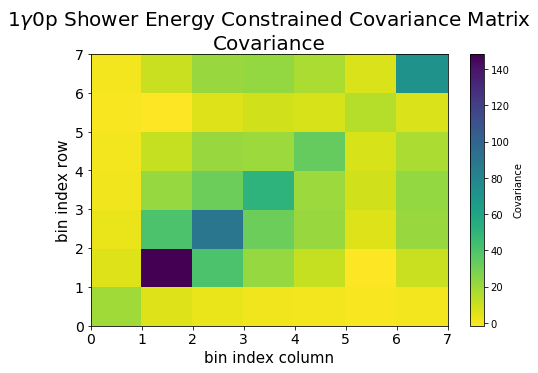

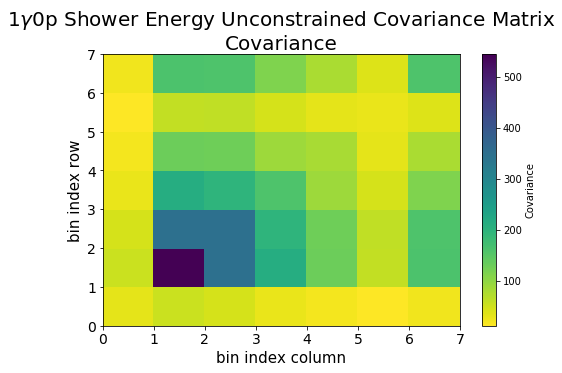

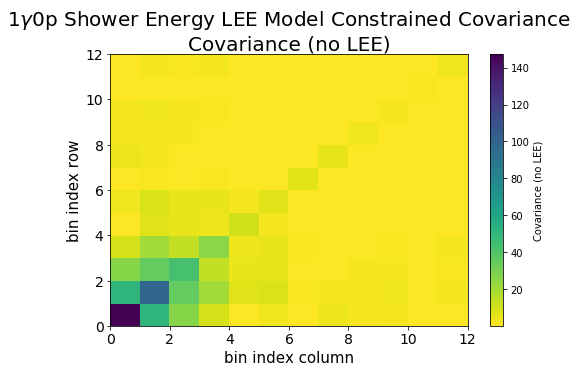

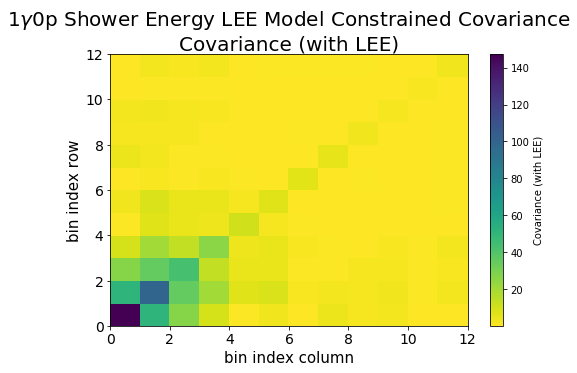

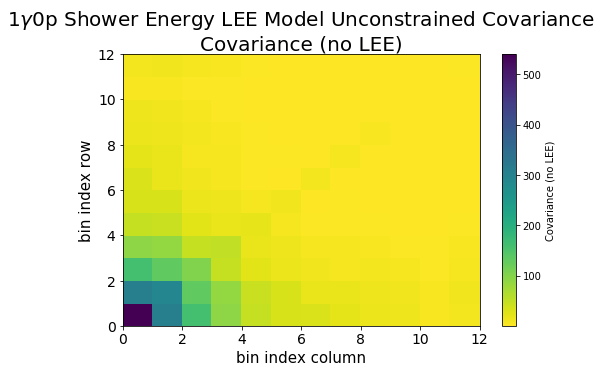

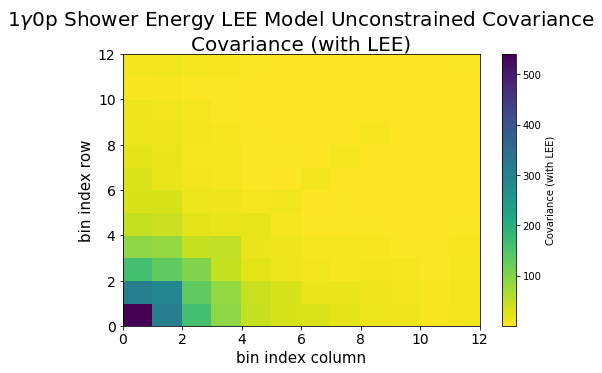

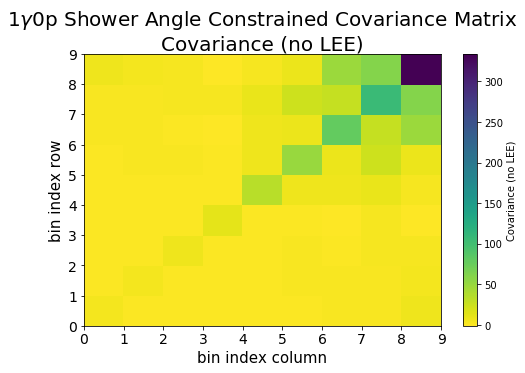

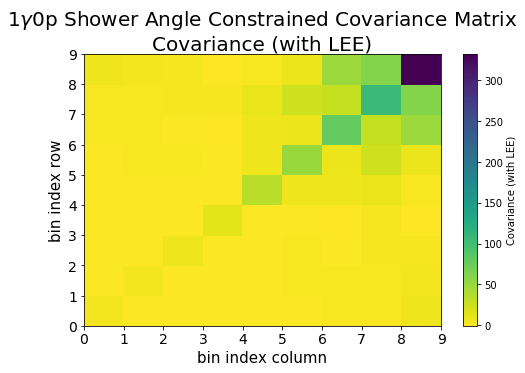

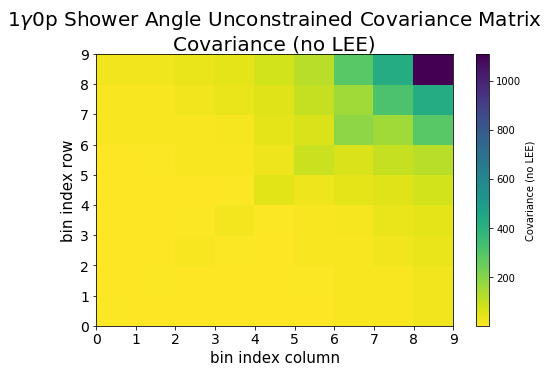

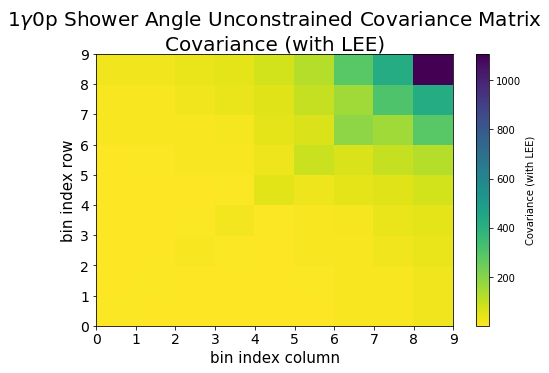

In [7]:
for i in range(len(yaml_names)):
    
    #### PULL 2D DATASET X-AXIS #######
    
    #Check for 2D, 2 and only 2 indepedent variables
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[yaml_names[i]]["independent_variables"][0]
    indep_var2 = yaml_dict[yaml_names[i]]["independent_variables"][1]
    var1_header = yaml_dict[yaml_names[i]]["independent_variables"][0]["header"]
    var2_header = yaml_dict[yaml_names[i]]["independent_variables"][1]["header"]

    assert len(indep_var1["values"]) == len(indep_var2["values"])
    
    #### PULL DATASET COLUMNS, if more than 1, make more than 1 plot ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values per column
    data_series = {}
    for entry in data_list:
        name = entry['header']['name']
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])

        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))
        X_low = (X[1:] - X[:-1])/2 #bin sizes for plots
        Y_low = (Y[1:] - Y[:-1])/2

        # Fill Z matrix
        for xi in range(len(X)):
            for yi in range(len(Y)):
                Z[xi, yi] = z_values[xi*len(Y)+yi]
        plt.figure(figsize=(8, 5))
        X_plot = np.append(X, X[-1]+2*X_low[-1]) #pcolormesh needs len(X) + 1 to plot all of Z
        Y_plot = np.append(Y,Y[-1]+2*Y_low[-1]) #pcolormesh needs len(Y) + 1 to plot all of Z
        plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis_r')  # Transpose Z to match orientation

        # Format plot
        plt.title(yaml_name_pretty[i] + '\n' + name,fontsize=20)
        plt.colorbar(label=name)
        plt.xlabel(var1_header["name"],fontsize=15)
        plt.ylabel(var2_header["name"],fontsize=15)
        plt.xticks(fontsize=14)  # Bigger x-axis ticks
        plt.yticks(fontsize=14) 
        #plt.legend()
        plt.savefig(yamlDir + "/plot_" + yaml_names[i] + "_" + zvar_name + ".png")

## Calculate Pearson Chi^2 while Matching Covariance to 1D plots

In [28]:
for i in range(len(file_name_cov)):
    name_cov = file_name_cov[i]
    file_here = file_list_cov[i]
    
    data_list = yaml_dict[file_here]["dependent_variables"]
    assert len(yaml_dict[file_here]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[file_here]["independent_variables"][0]
    indep_var2 = yaml_dict[file_here]["independent_variables"][1]
    var1_header = yaml_dict[file_here]["independent_variables"][0]["header"]
    var2_header = yaml_dict[file_here]["independent_variables"][1]["header"]
    
    #### Go through 1D datasets and check for corresponding covariance matrix #####
    for j in range(len(file_name_1D)):
        name_1D = file_name_1D[j]
        if "1$\gamma$0p Shower Energy LEE Model" in name_cov: #Specific case needed for this LEE model name
            if name_1D == "1$\\gamma$0p Shower Energy - LEE Model":
                file_match_1D = file_list_1D[j]
                print(name_1D, " + ", name_cov)
                break
        else:
            if name_1D in name_cov:
                file_match_1D = file_list_1D[j]
                print(name_1D, " + ", name_cov)
                break
                
    ### Get constrain or unconstrained ###
    data_list_1D = yaml_dict_1D[file_match_1D]["dependent_variables"]
    data_series_1D, size, names_1D_cols_here = pull_dependent_vars(data_list_1D) 
    constrain_type = None
    if "Constrained" in name_cov:
        constrain_type = "Constrained"
    elif "Unconstrained" in name_cov:
        constrain_type = "Unconstrained"
    else:
        print("Not sure what type of constrain to look for???")
    
    # Load covariance matrix (same as above)
    for entry in data_list:    
        name = entry['header']['name']
        #print(name, names_1D_cols_here)
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])
        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))

        # Fill Z matrix
        for xi in range(len(X)):
            for yi in range(len(Y)):
                Z[xi, yi] = z_values[xi*len(Y)+yi]
        cov_matrix = np.array(Z)
        
        
        # Match to the 1D column data (may be multiple)
        pred_name = None
        for name_here in names_1D_cols_here:        
            if "Data" in name_here:
                data_name = name_here
            elif ("Prediction" in name_here) and (constrain_type in name_here):
                # Check if you have LEE model and then compare with the LEE/no LEE case
                if "no LEE" in name: 
                    if "no LEE" in name_here:
                        pred_name = name_here
                        break
                elif "with LEE" in name:
                    if "with LEE" in name_here:
                        pred_name = name_here
                        break
                else:
                    pred_name = name_here
                    break
            else:
                continue
        
        full_data = np.array(data_series_1D[data_name]["values"])
        full_pred = np.array(data_series_1D[pred_name]["values"])
        stat_cov = np.diag(full_pred) #Add MC statistical uncertainty to covariance matrix
        
        #Adjust if low stats, using Pearson Chi^2 method
        mu_cut_off = np.array([0, 0.461, 0.916, 1.382, 1.833, 2.298, 2.767, 3.225, 3.669, 4.141, 4.599])
        for lsd in range(len(full_data)):
            data_as_int = int(np.ceil(full_data[lsd]))
            if data_as_int>=1 and data_as_int<=10:
                if full_pred[lsd] < mu_cut_off[data_as_int]:
                    num = (full_pred[lsd]-full_data[lsd])**2
                    den = 2 * (full_pred[lsd] - full_data[lsd] + full_data[lsd] * np.log(full_data[lsd] / full_pred[lsd]))
                    if (full_pred[lsd] == full_data[lsd]) and (full_pred[lsd] == 0):
                        new_diag = 1e-6
                    else:
                        new_diag = num / den
                    stat_cov[lsd][lsd] = new_diag
            
            else:
                continue
        
        # Add final determination of statistical covariance to given covariance matrix
        total_cov = cov_matrix + stat_cov
        
        chi2 = np.linalg.multi_dot(
            [np.transpose(full_pred - full_data),
             np.linalg.inv(total_cov), 
             full_pred - full_data])
        dof = len(full_data)
        print(name, chi2, "/", dof)

1$\gamma$Xp Shower Energy  +  1$\gamma$Xp Shower Energy Constrained Covariance Matrix
Covariance 23.049824158447986 / 16
1$\gamma$Xp Shower Energy  +  1$\gamma$Xp Shower Energy Unconstrained Covariance Matrix
Covariance 14.073964986993794 / 16
1$\gamma$Xp Shower Angle  +  1$\gamma$Xp Shower Angle Constrained Covariance Matrix
Covariance 18.26865263419799 / 9
1$\gamma$Xp Shower Angle  +  1$\gamma$Xp Shower Angle Unconstrained Covariance Matrix
Covariance 10.727779901535623 / 9
1$\gamma$0p Shower Energy  +  1$\gamma$0p Shower Energy Constrained Covariance Matrix
Covariance 14.395266703435098 / 7
1$\gamma$0p Shower Energy  +  1$\gamma$0p Shower Energy Unconstrained Covariance Matrix
Covariance 9.183753410014003 / 7
1$\gamma$0p Shower Energy - LEE Model  +  1$\gamma$0p Shower Energy LEE Model Constrained Covariance
Covariance (no LEE) 23.93174500354359 / 12
Covariance (with LEE) 19.873787063107557 / 12
1$\gamma$0p Shower Energy - LEE Model  +  1$\gamma$0p Shower Energy LEE Model Unconstrai